# 2. Languages of Journals using OJS <a name=languages></a>

<a href='https://docs.google.com/document/d/103l90P0OuM0muOsmUYlnProG_Xo9yBR4IQ6INB21WaE/edit?usp=sharing'>This link</a> navigates to a Google doc with examples of online journals using OJS to publish open access articles in **60 different languages**. <br>

### Notebook objectives:
1. [Obtain gcld3 language predictions for the abstracts of the most recent 100 articles published in a sample of 22,561 ISSN-verified journals actively using OJS.](#gcld3)
    * Google's Compact Language Detector v3 (https://github.com/google/cld3), a pretrained model for language classification
   <br><br>
2. [Verify gcld3 language predictions for each journal using a variety of heuristics, including:](#verify)
    * Checking language predictions against journal top-level domains (e.g., "es" for Spanish and ".es" for Spain)
    * Cross-checking language predictions for article abstracts, article titles, and journal titles
    * Manually checking frequent misclassifications, such as Japanese, Scottish Gaelic, and Afrikaans
   <br><br>
3. [Visualize journals by their primary language of publishing:](#primary)
    * [Top 10 languages](#top10)
    * [All languages in the dataset](#all)
    <br><br>
4. [Classify journals based on whether they publish in multiple languages.](#multi)

Import packages:

In [1]:
from collections import defaultdict
from collections import Counter
from lxml import html
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import json
import time
import re
import os

## Google's Compact Language Detector v3 (gcld3) <a id='gcld3'></a>

Initialize <a href='https://github.com/google/cld3'>gcld3</a>:

In [2]:
import gcld3
classifier = gcld3.NNetLanguageIdentifier(min_num_bytes=0, max_num_bytes=10000)

Store a list of gcld3 language codes corresponding to the <a href='https://docs.google.com/document/d/103l90P0OuM0muOsmUYlnProG_Xo9yBR4IQ6INB21WaE/edit?usp=sharing'>60 different publishing languages in OJS use</a> (except Faroese and Balochi, which are unsupported by gcld3):

In [3]:
known_langs = ['af', 'al', 'ar', 'bg', 'bg-Latn', 'bs', 'ca', 'cs', 'da', 'de', 'el', 'el-Latn', 'en', 'es', 'et', 
               'eu','fa', 'fi', 'fil', 'fr', 'gd', 'gl', 'hi', 'hi-Latn', 'hr', 'hu', 'hy', 'id', 'ig', 'is', 'it', 
               'ja','ja-Latn', 'ka', 'kk', 'ko', 'ku', 'lt', 'mk', 'ms', 'ne', 'nl', 'no', 'pl', 'pt', 'ro', 'ru', 
               'ru-Latn','si','sk', 'sl', 'sr', 'sv', 'sw', 'ta', 'th', 'tr', 'uk', 'ur', 'uz', 'vi', 'zh', 'zh-Latn']

Create a function that:
<br>
1. Opens and streams a messy 28.5 GB file of scraped and printed OAI-PMH article metadata [title, description, subject, language, source...] for all articles published in **22,561 unique OJS contexts, or journals**;
<br><br>
2. Filters journals by ISSN and filters language predictions by inclusion in the list of known OJS languages (to avoid misclassification);
<br><br>
3. Passes the 'description' values (article abstracts) for the **most recent 100 articles published in each journal** to gcld3 to generate lists of predicted languages for each journal;
<br><br>
4. Returns a dict mapping journal issn to a list of gcld3-predicted language codes for article abstracts:

In [4]:
def classify_abstracts(path_to_dump, classifier, issn_filter, lang_filter):
    
    metadata_pattern = '<metadata>.+</metadata>'
    issn2langs = defaultdict(list) #defaultdict of lists
    dcount = defaultdict(int)
    #Full processing
    
    with open(path_to_dump, 'r') as f:
        article_count = 0
        
        for line in f:
            content = re.search(metadata_pattern, line, re.MULTILINE | re.DOTALL)
            if content:
                tree = html.fromstring(content.group())

                for article in tree.xpath('//metadata'):
                    article_count += 1
                    
                    for source in article.xpath('.//source'):
                        source_copy = str(source.text)
                        source_copy = re.sub('\s', '', source_copy)
                        if source_copy in issn_filter:
                            issn = source_copy
                            for description in article.xpath('.//description'):
                                if dcount[issn] < 100 and description is not None: #if <100 abstracts have been classified
                                    pred_ = classifier.FindLanguage(text=description.text) #run gcld3
                                    if pred_.is_reliable and pred_.language in lang_filter: 
                                        #if the language prediction is reliable and in a known OJS language
                                        issn2langs[issn].append(pred_.language)
                                        #append to a list of language predictions for the journal
                                        dcount[issn] += 1
                                    del pred_
                                        
                while tree.getprevious() is not None:
                    del tree.getparent()[0]
            del content
    
    print(f"Articles scanned: {article_count}")
    print(f"Journals classified: {len(issn2langs)}")
    print(f"Missing issns: {set(issn_filter) - set(list(issn2langs.keys()))}")
    return issn2langs

In [5]:
path_to_dump = os.path.join('data', 'datadump.txt')
path_to_beacon = os.path.join('data', 'beacon_active.csv')

In [6]:
with open(path_to_beacon, 'r') as f:
    df = pd.read_csv(f)
df = df[~df['issn_1'].duplicated()]
issn_filter = [i for i in df['issn_1'].tolist() if isinstance(i, str)]
print(len(issn_filter))

22809


In [7]:
%time issn2langs = classify_abstracts(path_to_dump, classifier, issn_filter, lang_filter=known_langs)

Articles scanned: 7960979
Journals classified: 22559
Missing issns: {'2501-9430', '1047-6857', '2364-3714', '2525-8281', '1856-6073', '1678-9059', '2451-3962', '2358-1069', '2540-8445', '2721-5148', '2798-6241', '2655-2469', '2721-6020', '2734-9314', '2528-4967', '2734-9330', '1411-6340', '2775-5592', '2302-8432', '2355-1720', '2477-5029', '2503-3417', '1668-8708', '2615-6911', '2721-9976', '2598-0637', '1096-746X', '2451-1862', '2222-6737', '2775-1937', '2153-4012', '2600-5689', '1411-2280', '2722-3736', '2086-7840', '2183-0134', '1747-7387', '1693-4458', '2538-399X', '2501-2428', '0436-0265', '2716-3679', '2316-5324', '2655-948X', '2597-8985', '2621-783X', '2722-7960', '2620-5068', '1549-4497', '2598-9626', '2722-7111', '2723-1186', '2580-3123', '2460-352X', '2686-4908', '2622-5867', '1693-461X', '1754-4270', '2685-2799', '2614-4042', '2085-8744', '0124-1192', '2359-1382', '2622-6138', '2602-0254', '2668-9928', '1216-6804', '0103-4979', '0797-8952', '2215-9827', '2723-5319', '2339-14

Sanity check:

In [8]:
with open(os.path.join('data', 'issn2langs.json'), 'w') as outfile:
    json.dump(issn2langs, outfile)
print(type(issn2langs))
for k, v in issn2langs.items():
    print(k) #issn for one journal
    print(v) #list of gcld3 language classifications for most recent 100 or fewer articles published in journal
    break

<class 'collections.defaultdict'>
2715-2502
['id', 'en', 'id', 'id', 'id', 'id', 'id', 'en', 'id', 'en', 'en', 'id', 'id', 'ms', 'id', 'en', 'id', 'en', 'id', 'id', 'en']


## Verifying gcld3-predicted language codes for each journal <a id='verify'></a>

#### Data
Create a DataFrame, `AA`, that joins gcld3-predicted language codes with data from the beacon. This DataFrame will be used to verify gcld3 language predictions for each journal.

In [10]:
#reload dict {issn: list of gcld3-predicted language codes}
with open(os.path.join('data','issn2langs.json'), 'r') as infile:
    issn2langs = json.load(infile)
#load dict {issn: text sample of concatenated titles and abstracts}
with open(os.path.join('data','issn2payload.json'), 'r') as infile:
    issn2payload = json.load(infile)

In [11]:
#{issn: primary language}
l1 = {}
for k, v in issn2langs.items():
    l1[k] = Counter(v).most_common(1)[0][0]
#{issn: secondary language}
l2 = {}
for k, v in issn2langs.items():
    try:
        l2[k] = Counter(v).most_common(2)[1][0]
    except IndexError:
        l2[k] = None
        continue

In [12]:
# issn | primary language predicted by gcld3 | secondary language predicted by gcld3
dfL = pd.DataFrame({'issn': l1.keys(),
                    'pred_1': l1.values(),
                    'pred_2': l2.values(),
                    })
# issn | text sample of concatenated titles and abstracts
dfP = pd.DataFrame({'issn': issn2payload.keys(),
                    'text':issn2payload.values()})
# issn | primary language | secondary language | text sample
dfA = pd.merge(dfL, dfP, how='outer')

In [13]:
#load beacon data
with open('data/beacon_active.csv', 'r') as infile:
    bA = pd.read_csv(infile)
#select beacon columns useful for language verification  
bA = bA[['context_name', 'issn_1', 'issn_2', 'country_consolidated', 'journal_url']].copy()

In [14]:
#rename then merge into AA
bA.rename(columns = {'issn_1':'issn',
                     'issn_2':'issn_alt',
                     'country_consolidated':'tld'}, inplace = True)
AA = pd.merge(dfA, bA, on='issn')
#AA.to_csv('data/AA.csv')

In [15]:
#deduplicate issns
AA = AA[~AA['issn'].duplicated()]
#lowercase top-level domains
AA['tld'] = AA['tld'].str.lower()
AA['pred_1'].unique()

array(['id', 'af', 'en', 'ms', 'es', 'ar', 'pt', 'th', 'ca', 'el', 'uk',
       'it', 'fr', 'is', 'de', 'no', 'ja', 'ru', 'tr', 'sv', 'hi', 'pl',
       'sr', 'sl', 'cs', 'da', 'vi', 'lt', 'hu', 'hr', 'mk', 'zh', 'ta',
       'kk', 'sw', 'gd', 'sk', 'et', 'fa', 'bs', 'eu', 'ro', 'bg', 'fil',
       'ka', 'hy', 'uz', 'nl', 'fi', 'ne', 'ig', nan], dtype=object)

#### Helper functions:

Function for applying gcld3 to journal titles and article-level text samples:

In [16]:
def tag_language(s):
    l = classifier.FindLanguage(text=s)
    if l.is_reliable:
        return l.language

In [17]:
AA['title_language'] = pd.Series([tag_language(s) if isinstance(s, str) else None for s in AA['context_name'].tolist()])
AA['text_language'] = pd.Series([tag_language(s) if isinstance(s, str) else None for s in AA['text'].tolist()])

Function for adding journal issns and double-checked language predictions to a cleaned dict `clean_d`:

In [18]:
def add2dict(d, issns, langs, corrections=False):
    count = 0
    corrs = 0
    for issn, l2 in zip(issns, langs):
        if corrections:
            d[issn] = l2
            corrs += 1
            continue
        else:
            if issn in d:
                continue
            else:
                d[issn] = l2
                count += 1
    print(f"{count} journal(s) added;\n{corrs} journals corrected;\n{len(d)} journals cleaned and stored in total")

In [19]:
clean_d = {}

### Heuristic approach to language verification:

#### 1. Add a <a href='http://fsj.um.fo/ojs/index.php/frit'>Faroese</a> journal and a <a href='http://pscjournal.uob.edu.pk/journal/index.php/hanken/index'>Balochi</a> journal, both of which are misclassified in the data set:

In [20]:
add2dict(d=clean_d,
         issns=['2445-6144', '2710-4850'],
         langs=['Faroese', 'Balochi'])

2 journal(s) added;
0 journals corrected;
2 journals cleaned and stored in total


#### 2. If a journal has a nonnull `pred_1` value but a null `pred_2` value, it is probably publishing in language `pred_1` (because  the most recent 100 article abstracts were all tagged with a single language code, `pred_1`):

In [21]:
add2dict(d=clean_d,
         issns=AA[(AA['pred_1'].notnull()) & (AA['pred_2'].isna())].issn.tolist(),
         langs=AA[(AA['pred_1'].notnull()) & (AA['pred_2'].isna())].pred_1.tolist())

5791 journal(s) added;
0 journals corrected;
5793 journals cleaned and stored in total


#### 3. If gcld3 predicts the same primary language for a journal's title metadata `title_language`, article metadata `text_language`, and abstracts from the most recent 100 articles published `pred_1`, add the journal:

In [22]:
add2dict(d=clean_d,
         issns=AA[(AA['pred_1'] == AA['text_language']) & (AA['pred_1'] == AA['title_language'])].issn.tolist(),
         langs=AA[(AA['pred_1'] == AA['text_language']) & (AA['pred_1'] == AA['title_language'])].pred_1.tolist())

1172 journal(s) added;
0 journals corrected;
6965 journals cleaned and stored in total


#### 4. If the journal's secondary language `pred_2` matches its top level domain `tld` and the primary language predicted by gcld3 `pred_1` is not English, `pred_1` is probably an error, so add `pred_2`:

In [23]:
add2dict(d=clean_d,
         issns=AA[(AA['pred_2'] == AA['tld']) & (AA['pred_1'] != 'en')].issn.tolist(),
         langs=AA[(AA['pred_2'] == AA['tld']) & (AA['pred_1'] != 'en')].pred_2.tolist())

116 journal(s) added;
0 journals corrected;
7081 journals cleaned and stored in total


#### 5. Check if journals with an `af` Afrikaans primary language classification actually have an African top-level domain `tld`:

In [24]:
#store list of African country top-level domains
af_tlds = ['AO','BI','BJ','BF','BW','CF','CI','CM','CD','CG','KM','CV','ER','ET','GA','GH',
           'GN','GM','GW','GQ','KE','LR','LS','MG','ML','MZ','MR','MU','MW','NA','NE','NG',
           'RW','SD','SN','SL','SO','SS','ST','SZ','SC','TD','TG','TZ','UG','ZA','ZM','ZW']
AA['is_af'] = AA['tld'].apply(lambda x: any([i.lower() for i in af_tlds if i.lower() == x]))
#AA[((AA['pred_1'] == 'af') | (AA['pred_2'] == 'af')) & (AA['is_af'] == True)]

In [25]:
add2dict(d=clean_d,
         issns=['1013-1116', '0041-4751', '0041-476X', '0254-3486', '2006-1390'],
         langs=['af', 'af', 'af', 'af', 'en'])

5 journal(s) added;
0 journals corrected;
7086 journals cleaned and stored in total


#### 6. Assuming that all remaining `pred_1` == `af` are misclassifications, add `pred_2` instead:

In [26]:
add2dict(d=clean_d,
         issns=AA[(AA['pred_1'] == 'af')].issn.tolist(),
         langs=AA[(AA['pred_1'] == 'af')].pred_2.tolist())

70 journal(s) added;
0 journals corrected;
7156 journals cleaned and stored in total


#### 7. If journals with an `es` Spanish primary language classification also have a Latin American top-level domain `tld`, they are probably publishing in Spanish:

In [27]:
latam_tlds = ['AW','AR','AG','BS','BZ','BO',#'BR', not brazil! bc portuguese
              'BB','CL','CO','CR','CU','CW','KY','DM','DO','EC','GD','GT','GY','HN','HT','JM','KN','LC',
              'GP','MX','NI','PA','PE','PR','PY','SV','SR','AN','SX','TC','TT','UY','VC','VE','VG','VI']
AA['is_latam'] = AA['tld'].apply(lambda x: any([i.lower() for i in latam_tlds if i.lower() == x]))
AA['is_latam'].value_counts()

False    20123
True      2468
Name: is_latam, dtype: int64

In [28]:
add2dict(d=clean_d,
         issns=AA[(AA['pred_1'] == 'es') & (AA['is_latam'] == True)].issn.tolist(),
         langs=AA[(AA['pred_1'] == 'es') & (AA['is_latam'] == True)].pred_1.tolist())

1681 journal(s) added;
0 journals corrected;
8837 journals cleaned and stored in total


#### 8. Japanese journals, jointly identified by language prediction `ja` and top-level domain `jp`:

In [29]:
add2dict(d=clean_d,
         issns=AA[(AA['pred_1'] == 'ja') & (AA['tld'] == 'jp')].issn.tolist(),
         langs=AA[(AA['pred_1'] == 'ja') & (AA['tld'] == 'jp')].pred_1.tolist())

2 journal(s) added;
0 journals corrected;
8839 journals cleaned and stored in total


#### 9. Japanese again, with the assumption that all remaining `pred_1` == `ja` are misclassifications, so add `pred_2` instead:

In [30]:
add2dict(d=clean_d,
         issns=AA[(AA['pred_1'] == 'ja')].issn.tolist(),
         langs=AA[(AA['pred_1'] == 'ja')].pred_2.tolist())

63 journal(s) added;
0 journals corrected;
8902 journals cleaned and stored in total


#### 10. Manually enter correct language codes for misclassified French examples:

In [31]:
#pd.set_option("display.max_rows", None)
#AA[(AA['pred_1'] == 'fr') & (AA['pred_2'].notnull())]

In [32]:
add2dict(d=clean_d,
         issns=['0008-4123', '2341-0868', '2595-6752', '1026-2881', '2368-8076', '2665-7716', '0702-7818',
                '1496-7308', '0002-4805', '1544-4953', '1499-6677', '0705-3657', '2605-0285'],
         langs=['en', 'es', 'pt', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en'])

13 journal(s) added;
0 journals corrected;
8915 journals cleaned and stored in total


#### 11. Malay journals, jointly identified by primary language prediction `ms` and top-level domain `my`:

In [33]:
add2dict(d=clean_d,
         issns=AA[(AA['pred_1'] == 'ms') & (AA['tld'] == 'my')].issn.tolist(),
         langs=AA[(AA['pred_1'] == 'ms') & (AA['tld'] == 'my')].pred_1.tolist())

36 journal(s) added;
0 journals corrected;
8951 journals cleaned and stored in total


#### 12. Brazilian journals, jointly identified by primary language prediction `pt` and top-level domain `br`:

In [34]:
add2dict(d=clean_d,
         issns=AA[(AA['pred_1'] == 'pt') & (AA['tld'] == 'br')].issn.tolist(),
         langs=AA[(AA['pred_1'] == 'pt') & (AA['tld'] == 'br')].pred_1.tolist())

1762 journal(s) added;
0 journals corrected;
10713 journals cleaned and stored in total


#### 13. German journals, jointly identified by primary language prediction `de` and top-level domain `de`:

In [35]:
add2dict(d=clean_d,
         issns=AA[(AA['pred_1'] == 'de') & (AA['tld'] == 'de')].issn.tolist(),
         langs=AA[(AA['pred_1'] == 'de') & (AA['tld'] == 'de')].pred_1.tolist())

69 journal(s) added;
0 journals corrected;
10782 journals cleaned and stored in total


#### 14. Hindi journals, jointly identified by primary language prediction `hi` | `hi-Latn` and top-level domain `in`:

In [36]:
add2dict(d=clean_d,
         issns=AA[(AA['pred_1'] == 'hi') | (AA['pred_1'] == 'hi-Latn') & (AA['tld'] == 'in')].issn.tolist(),
         langs=AA[(AA['pred_1'] == 'hi') | (AA['pred_1'] == 'hi-Latn') & (AA['tld'] == 'in')].pred_1.tolist())

2 journal(s) added;
0 journals corrected;
10784 journals cleaned and stored in total


#### 14. Manually check OJS contexts with a Philippines top-level domain (.ph):

In [37]:
#AA[(AA['tld'] == 'ph') & (AA['pred_2'].notnull())]

In [38]:
add2dict(clean_d,
         issns=['0012-2858', '2244-6001'],
         langs=['en', 'fil'],
         corrections=True)

0 journal(s) added;
2 journals corrected;
10784 journals cleaned and stored in total


#### 15. Manually check OJS contexts with a Danish top-level domain (.dk):

In [39]:
#AA[(AA['tld'] == 'dk') & (AA['pred_2'].notnull())]

In [40]:
add2dict(d=clean_d,
         issns=['2596-6200', '0909-0533', '2446-0591', '2446-3981', '2597-0704', 
                '1603-8509', '2246-2589', '2244-9140', '1904-5565', '0029-1528'],
         langs=['da', 'da', 'da', 'en', 'da', 'da', 'da', 'da', 'da', 'da'])

9 journal(s) added;
0 journals corrected;
10793 journals cleaned and stored in total


#### 16. Manually check musicological journals, becuase musical notation makes problems for gcld3:

In [41]:
#AA[AA['context_name'].str.contains('musi[ck]', regex=True, case=False)]

In [42]:
add2dict(d=clean_d,
         issns=['0354-818X', '2312-2528'],
         langs=['sr', 'en'])

2 journal(s) added;
0 journals corrected;
10795 journals cleaned and stored in total


In [43]:
add2dict(clean_d,
         issns=['0011-3735'], #current musicology, which gcld3 classified as Japanese and Gaelic
         langs=['en'], #https://currentmusicology.columbia.edu/
         corrections=True)

0 journal(s) added;
1 journals corrected;
10795 journals cleaned and stored in total


#### 17. Manually check all Scottish Gaelic `gd` contexts:

In [44]:
#AA[(AA['pred_1'] == 'gd') | (AA['pred_2'] == 'gd')]

In [45]:
add2dict(clean_d,
         issns=['1754-4270', #perhaps the only true Scottish Gaelic journal
                '0035-6867', '2675-1127', '0957-5286'],
         langs=['gd', 'it', 'pt', 'en'])

4 journal(s) added;
0 journals corrected;
10799 journals cleaned and stored in total


In [46]:
add2dict(clean_d,
         issns=['1805-9511', '0252-9076', '2563-562X'],
         langs=['cs', 'es', 'en'],
         corrections=True)

0 journal(s) added;
3 journals corrected;
10799 journals cleaned and stored in total


#### 18. Manually check contexts with a Czech top-level domain `cz` :

In [47]:
#AA[AA['tld'] == 'cz']

In [48]:
add2dict(clean_d,
         issns=['0009-2770', '2336-2766', '2336-3630', '1805-9511', '2336-4378',
                '1802-3983', '1804-5383', '1804-6665', '2694-9288'],
         langs=['cs', 'cs', 'uk', 'cs', 'cs', 'cs', 'cs', 'cs', 'cs'],
         corrections=True)

0 journal(s) added;
9 journals corrected;
10804 journals cleaned and stored in total


#### 19. Manually check contexts with an Albanian top-level domain `al` :

In [49]:
#pd.set_option("display.max_rows", None)
#AA[AA['tld']=='al']

In [50]:
add2dict(clean_d,
         issns=['2523-6636'],
         langs=['sq'],
         corrections=True)

0 journal(s) added;
1 journals corrected;
10804 journals cleaned and stored in total


#### 20. Manually check contexts with a Pakistani top-level domain `pk` :

In [51]:
#AA[AA['tld']=='pk']

In [52]:
#The output below is an error -- 11 journals added, 33 journals corrected
add2dict(clean_d,
         issns=['2663-6255', '0430-4055', '1813-775X', '2707-1200', '2411-6211', '1995-7904', '2520-5021', 
                '1998-4472', '2708-8235', '2073-5146', '2707-6903', '2664-4959', '2708-8847', '1816-5389', 
                '2709-8885', '2664-1461', '2305-1345', '2708-6577', '2618-1355', '1818-9296', '2664-0023', 
                '2709-6076', '2709-7641', '2709-4022', '2709-4162', '2710-0227', '2710-0812', '2410-8065', 
                '2521-408X', '2707-6288', '2617-9075', '2305-154X', '2710-2475', '2710-5180', '2707-7225', 
                '2523-0093', '2521-8948', '2788-4627', '2709-7617', '2073-3674', '2413-7480', '2415-5500', 
                '2519-6618', '2518-5330'],
         langs=['ur', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 
                'ur', 'Balochi', 'ur', 'ur', 'ur', 'ur', 'ar', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 
                'ur', 'ur', 'ur', 'ur', 'ar', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 'ur', 'ar', 'ur', 'ur'],
         corrections=True)

0 journal(s) added;
44 journals corrected;
10815 journals cleaned and stored in total


#### 21. Manually check journals that were predicted as Arabic `ar` :

In [53]:
#AA[(AA['pred_1'] == 'ar') | (AA['pred_2'] == 'ar')]

In [54]:
#The output below is an error -- 20 journals added, 5 journals corrected
add2dict(clean_d,
         issns=['1693-3257', '2700-8355', '2600-7398', '2410-1036', '2600-7398', '2223-859X', '1996-9546',
                '2071-9728', '1026-3748', '1026-3721', '1995-8005', '2460-5360', '2716-5515', '0552-265X',
                '1994-473X', '2663-7405', '2437-0789', '2522-3259', '2522-6460', '2421-9843', '2520-7431',
                '2664-4673', '2706-9524', '1658-7030', '1658-3116'],
         langs=['ar', 'ar', 'ar', 'ku', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'id', 'ar', 'ar', 'ar',
                'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar', 'ar'],
         corrections=True)

0 journal(s) added;
25 journals corrected;
10835 journals cleaned and stored in total


#### 22. Manually check contexts with a Belarusian top-level domain `by` :

In [55]:
#AA[AA['tld']=='by']

In [56]:
add2dict(clean_d,
         issns=['2222-8853', '2789-195X', '2415-7198'],
         langs=['by', 'en', 'uk'],
         corrections=True)

0 journal(s) added;
3 journals corrected;
10837 journals cleaned and stored in total


#### 23. If a journal's primary language prediction `pred_1` and top-level domain `tld` match, add the journal:

In [57]:
add2dict(d=clean_d,
         issns=AA[AA['pred_1'] == AA['tld']].issn.tolist(),
         langs=AA[AA['pred_1'] == AA['tld']].pred_1.tolist())

5298 journal(s) added;
0 journals corrected;
16135 journals cleaned and stored in total


#### 24. If a journal has an Eastern European top-level domain `tld` and its secondary language prediction `pred_2` matches its `title_language`, it probably publishes in its secondary language (e.g., Ukrainian) but translates article metadata into English. So, add the secondary language on the assumption that `text_language` == `en` is an error due to translated article titles and abstracts:

In [58]:
ee_tlds = ['AL','AD','AM','AT','BG','BA','BY','CY','CZ','EE','GE','GR','GL','HR',
                 'HU','LT','LV','MD','MK','ME','PL','RO','RU','RS','SK','SI','UA']
AA['is_ee'] = AA['tld'].apply(lambda x: any([i.lower() for i in ee_tlds if i.lower() == x]))
#AA[(AA['pred_2'] == AA['title_language']) & (AA['pred_2'].notnull()) & (AA['is_ee'] == True)]

In [59]:
add2dict(d=clean_d,
         issns=AA[(AA['pred_2'] == AA['title_language']) & (AA['pred_2'].notnull()) & \
                  (AA['is_ee'] == True)].issn.tolist(),
         langs=AA[(AA['pred_2'] == AA['title_language']) & (AA['pred_2'].notnull()) & \
                  (AA['is_ee'] == True)].pred_2.tolist())

127 journal(s) added;
0 journals corrected;
16262 journals cleaned and stored in total


#### 25. Finally, add each remaining journal's primary language prediction `pred_1` to complete `clean_d`:

In [60]:
add2dict(d=clean_d,
         issns=AA[AA['pred_1'].notnull()].issn.tolist(),
         langs=AA[AA['pred_1'].notnull()].pred_1.tolist())

6299 journal(s) added;
0 journals corrected;
22561 journals cleaned and stored in total


## Visualizing the primary languages in which OJS users publish worldwide: <a id='primary'></a>

In [61]:
codes = {'af':'Afrikaans', 'ar':'Arabic', 'bg':'Bulgarian', 'bg-Latn':'Bulgarian', 'bs':'Bosnian', 'by':'Belarusian',
         'ca':'Catalan', 'cs':'Czech', 'da':'Danish', 'de':'German', 'el':'Greek', 'el-Latn':'Greek', 'en':'English', 
         'es':'Spanish', 'et':'Estonian', 'eu':'Basque', 'fa':'Persian', 'fi':'Finnish', 'fil':'Filipino',
         'fr':'French', 'ga':'Irish', 'gd':'Scottish Gaelic', 'gl':'Galician', 'hi':'Hindi','hi-Latn':'Hindi',
         'hr':'Croatian', 'hu':'Hungarian', 'hy':'Armenian', 'id':'Indonesian', 'ig':'Igbo', 'is':'Icelandic',
         'it':'Italian', 'iw':'Hebrew', 'ja':'Japanese', 'ja-Latn':'Japanese', 'ka':'Georgian', 'kk':'Kazakh',
         'ko':'Korean', 'ku':'Kurdish', 'la':'Latin', 'lt':'Lithuanian', 'lv':'Latvian', 'mk':'Macedonian',
         'ms':'Malay', 'my':'Burmese', 'ne':'Nepali', 'nl':'Dutch', 'no':'Norwegian', 'pl':'Polish',
         'pt':'Portuguese', 'ro':'Romanian', 'ru':'Russian', 'ru-Latn':'Russian', 'sd':'Sindhi', 'si':'Sinhala',
         'sk':'Slovak', 'sl':'Slovenian', 'sq':'Albanian', 'sr':'Serbian', 'sv':'Swedish', 'sw':'Swahili', 
         'ta':'Tamil', 'tg':'Tajik', 'th':'Thai', 'tr':'Turkish', 'uk':'Ukrainian', 'ur':'Urdu', 'uz':'Uzbek',
         'vi':'Vietnamese', 'zh':'Chinese', 'zh-Latn':'Chinese'}

Get primary language counts for the entire sample of journals, to be visualized using matplotlib and seaborn:

In [62]:
issn2primary = pd.DataFrame({'issn': list(clean_d.keys()),
                             'gcld3_code': [c if len(c) == 2 else None for c in clean_d.values()],
                             'language': [codes[l] if codes.get(l) else l for l in list(clean_d.values())]})
issn2primary = issn2primary[issn2primary['language'].notnull()]
#Get a series of value counts for the language codes
ls = issn2primary['language'].value_counts(sort=True, ascending=False)
print(f"Total: {ls.sum()} journals")

Total: 22561 journals


In [63]:
ojsLangs = AA[['issn', 'issn_alt', 'context_name', 'journal_url']].merge(issn2primary, how='left', on='issn')
ojsLangs = ojsLangs[ojsLangs['language'].notnull()].sort_values(by=['journal_url'])
print(ojsLangs.shape)
ojsLangs.head()

(22561, 6)


,issn,issn_alt,context_name,journal_url,gcld3_code,language
17064,1018-2888,2709-7951,Diagnóstico,http://142.44.242.51/index.php/diagnostico,es,Spanish
16672,2236-3785,NaN,Revista Ciências em Saúde,http://186.225.220.186:7474/ojs/index.php/rcsf...,pt,Portuguese
9466,2077-1371,2077-1460,Biosfera,http://21bs.ru/index.php/bio,en,English
5560,2089-4686,2548-5970,2-TRIK: TUNAS-TUNAS RISET KESEHATAN,http://2trik.jurnalelektronik.com/index.php/2trik,id,Indonesian
9854,2705-0513,NaN,工程技术研究,http://2winpub.usp-pl.com/index.php/ETR,zh,Chinese


In [64]:
ojsLangs.to_csv(os.path.join('data', 'OJS_languages_v3.csv'), index=False)

### Bar plot of the 10 primary languages in which OJS users publish their articles  (*n*=21,874) <a id='top10'></a><br>
Each bar represents the proportion of journals for which the specified language is their primary publishing language.

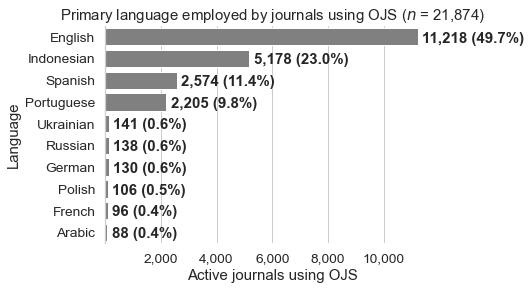

In [65]:
%matplotlib inline

sns.set(font_scale=1.25, style='whitegrid')
fig, ax = matplotlib.pyplot.subplots()

ld = sns.barplot(x=ls.values[:10],
                 y=ls.index[:10],
                 orient='h',
                 color='grey')

ax.set(xlim=(0, 12000),
       xlabel='Active journals using OJS',
       ylabel='Language',
       title='Primary language employed by journals using OJS ($\it{n}$ = 21,874)')

sns.despine(bottom=True)


matplotlib.pyplot.xticks([2000, 4000, 6000, 8000, 10000],
                         ['2,000', '4,000', '6,000', '8,000', '10,000'])

for p in ld.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.15
    percent = round(((p.get_width() / 22561) * 100), 1)
    string = str(int(p.get_width()))
    if len(string) == 5:
        value = string[:2] + ',' + string[2:]
    elif len(string) == 4:
        value = string[0] + ',' + string[1:]
    else:
        value = string
    value += ' ({})'.format(str(percent)+'%')
    ld.text(_x + 150, _y, value, ha='left', weight='bold')

fig.savefig(os.path.join('vis', 'OJS_primary_languages.png'), bbox_inches='tight')

### Bar plot of all the languages in which OJS users published their articles (*n*=22,561): <a id='all'></a>

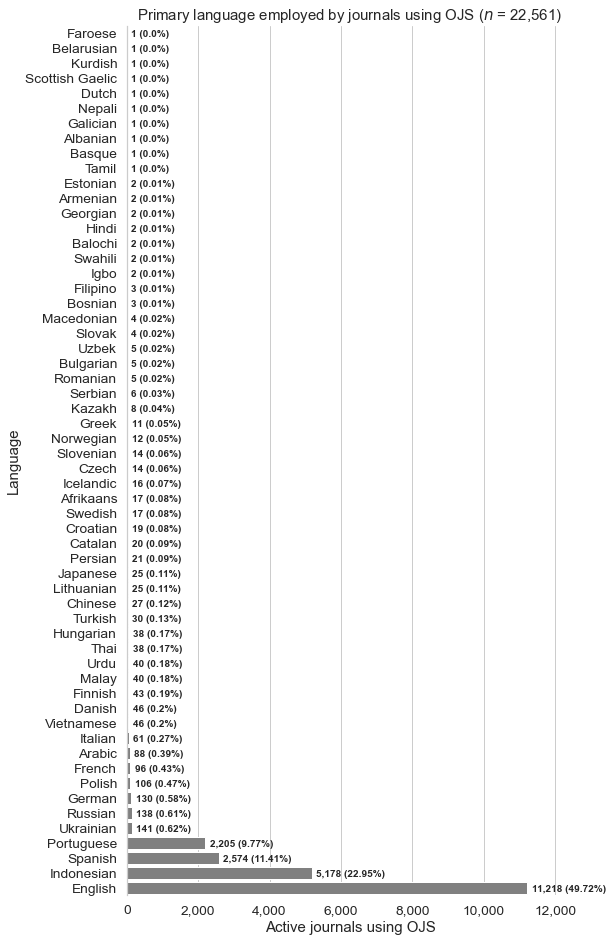

In [66]:
%matplotlib inline

fig, ax = matplotlib.pyplot.subplots(figsize=(8,16))

mult = sns.barplot(y=list(ls.sort_values().index),
                   x=list(ls.sort_values().values),
                   orient='h',
                   color='grey')

sns.despine(bottom=True)

ax.set(xlim=(0, 12500),
       xlabel='Active journals using OJS',
       ylabel='Language',
       title='Primary language employed by journals using OJS ($\it{n}$ = 22,561)',
       visible=True)

matplotlib.pyplot.xticks([0, 2000, 4000, 6000, 8000, 10000, 12000],
                         ['0', '2,000', '4,000', '6,000', '8,000', '10,000', '12,000'])

for p in mult.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.175
    percent = round(((p.get_width() / 22561) * 100), 2)
    string = str(int(p.get_width()))
    if len(string) == 5:
        value = string[:2] + ',' + string[2:]
    elif len(string) == 4:
        value = string[0] + ',' + string[1:]
    else:
        value = string
    value += ' ({})'.format(str(percent)+'%')
    mult.text(_x + 125, _y, value, ha='left', weight='bold')

fig.savefig(os.path.join('vis', 'OJS_languages_v3.png'), bbox_inches='tight')

### Bar plot of multilingualism among journals publishing with OJS  (*n*=22,382) <a id='multi'></a><br>
Each bar represents the proportion of journals that published **5 or more articles in each of their publishing languages**. The decision boundary of 5 was chosen to match the decision boundary for active journals (>=5 articles published per year).

In [67]:
def classify_journals_multi(issn2langs, decision_boundary):
    multilingual = defaultdict(list)
    for k, v in issn2langs.items():
        for lang in Counter(v).items():
            if lang[1] >= decision_boundary: 
                #If the the number of article abstracts tagged as a given language ('en') exceeds the boundary
                multilingual[k].append(lang[0]) #Append the language to a list for the journal
                
    multilingual_counts = defaultdict(int)
    array_lengths = []
    for v in multilingual.values():
        if v:
            multiplier = len(v)
            array_lengths.append(multiplier)
            if multiplier >= 3:
                multilingual_counts['Multi- (3+ languages)'] += 1
            elif multiplier == 2:
                multilingual_counts['Bi- (2 languages)'] += 1
            elif multiplier == 1:
                multilingual_counts['Mono- (1 language)'] += 1
            else:
                continue
            
    total = 0
    for v in multilingual_counts.values():
        total += v
    print('Total: {} journals'.format(total))
    print('Average number of languages per journal: {}'.format(np.array(array_lengths).mean()))
    
    return pd.Series(multilingual_counts).sort_values(ascending=False)

In [68]:
multi5 = classify_journals_multi(issn2langs, decision_boundary=5)

Total: 22382 journals
Average number of languages per journal: 1.6994013046197838


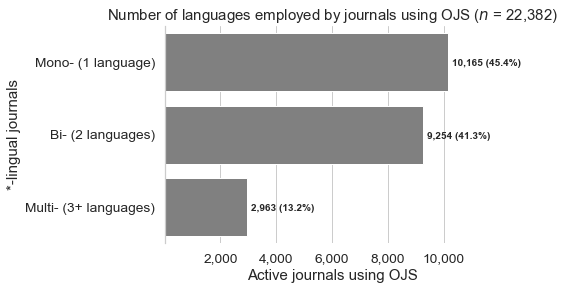

In [69]:
%matplotlib inline

fig, ax = matplotlib.pyplot.subplots()

mult = sns.barplot(y=multi5.index,
                   x=multi5.values,
                   orient='h',
                   color='grey')

ax.set(xlim=(0, 12000),
       xlabel='Active journals using OJS',
       ylabel='*-lingual journals',
       title='Number of languages employed by journals using OJS ($\it{n}$ = 22,382)')

sns.despine(bottom=True)

matplotlib.pyplot.xticks([2000, 4000, 6000, 8000, 10000],
                         ['2,000', '4,000', '6,000', '8,000', '10,000'])

for p in mult.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.35
    percent = round(((p.get_width() / 22382) * 100), 1)
    string = str(int(p.get_width()))
    if len(string) == 5:
        value = string[:2] + ',' + string[2:]
    elif len(string) == 4:
        value = string[0] + ',' + string[1:]
    else:
        value = string
    value += ' ({})'.format(str(percent)+'%')
    mult.text(_x + 150, _y, value, ha='left', weight='bold')

fig.savefig(os.path.join('vis', 'OJS_multilingual5.png'), bbox_inches=('tight'))